In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install utils
from utils import *
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy as np
import time
% matplotlib inline

batch_size=16
dataset = dset.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda:0


# Data Load

5


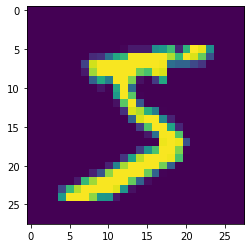

In [2]:
img, label = dataset[0]
plt.imshow(to_pil_image(img))
print(label)

# Model

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

# Weight init & Parameter

In [17]:
def weight_init(model):
  classname = model.__class__.__name__
  if classname.find("conv") != -1:
    torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm") != -1:
    torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(model.bias.data, 0.0)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 1024, kernel_size=(4, 4), stride=(2, 2))
    (10): LeakyReLU(negative_slope=0.2)
  )
  (adv_layer): Linear(in_features=1024, out_features=1, bias=True)
  (aux_layer): Linear(in_features=1024, out_features=10, bias=True)
  (latent_layer): Linear(in_features=1024, out_features=2, bias=True)
)

# train

In [23]:
class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll
def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

In [24]:
# Initialise the network.
netG = Generator().to(device)
netG.apply(weight_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weight_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weight_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weight_init)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=0.001, betas=(0.5, 0.99))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=0.001, betas=(0.5,0,99))

# Fixed Noise
z = torch.randn(100, 62, 1, 1, device=device)
fixed_noise = z
idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 1, 10, device=device)
dis_c[torch.arange(0, 100), i, idx] = 1.0

dis_c = dis_c.view(100, -1, 1, 1)

fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

con_c = torch.rand(100, 2, 1, 1, device=device) * 2 - 1
fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format("MNIST") % (30, 16, len(data_loader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(30):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(data_loader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(1, 10, 2, 62, b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        dis_loss += criterionQ_dis(q_logits[:, 2*10 : 2*10 + 10], target[2])

        # Calculating loss for continuous latent code.
        con_loss = 0
        con_loss = criterionQ_con(noise[:, 62+ 1*10 : ].view(-1, 2), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, 30, i, len(data_loader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    # epoch_time = time.time() - epoch_start_time
    # print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    # with torch.no_grad():
    #     gen_data = netG(fixed_noise).detach().cpu()
    # img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # # Generate image to check performance of generator.
    # if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
    #     with torch.no_grad():
    #         gen_data = netG(fixed_noise).detach().cpu()
    #     plt.figure(figsize=(10, 10))
    #     plt.axis("off")
    #     plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
    #     plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
    #     plt.close('all')

    # # Save network weights.
    # if (epoch+1) % params['save_epoch'] == 0:
    #     torch.save({
    #         'netG' : netG.state_dict(),
    #         'discriminator' : discriminator.state_dict(),
    #         'netD' : netD.state_dict(),
    #         'netQ' : netQ.state_dict(),
    #         'optimD' : optimD.state_dict(),
    #         'optimG' : optimG.state_dict(),
    #         'params' : params
    #         }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

# training_time = time.time() - start_time
# print("-"*50)
# print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
# print("-"*50)

# # Generate image to check performance of trained generator.
# with torch.no_grad():
#     gen_data = netG(fixed_noise).detach().cpu()
# plt.figure(figsize=(10, 10))
# plt.axis("off")
# plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
# plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# # Save network weights.
# torch.save({
#     'netG' : netG.state_dict(),
#     'discriminator' : discriminator.state_dict(),
#     'netD' : netD.state_dict(),
#     'netQ' : netQ.state_dict(),
#     'optimD' : optimD.state_dict(),
#     'optimG' : optimG.state_dict(),
#     'params' : params
#     }, 'checkpoint/model_final_{}'.format(params['dataset']))


# # Plot the training losses.
# plt.figure(figsize=(10,5))
# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(G_losses,label="G")
# plt.plot(D_losses,label="D")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.savefig("Loss Curve {}".format(params['dataset']))

# # Animation showing the improvements of the generator.
# fig = plt.figure(figsize=(10,10))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
# plt.show()

Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
 

RuntimeError: ignored